<a href="https://colab.research.google.com/github/adammuhtar/economic-strategy-text-mining/blob/main/UK_Economic_Strategy_Text_Mining_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text mining analysis of UK's economic strategy adoption among ministerial departments and government agencies
---
This notebook contains Python scripts used to extract and analyse texts from reports published by UK's (non-UKRI) state agencies housed directly under or working in close co-ordination with the UK's Department of Business, Energy and Industrial Strategy (BEIS) to identify the extent of UK's industrial policy rollout. This work builds from [Coyle and Adam (2021)](https://www.bennettinstitute.cam.ac.uk/publications/industrial-policy-learning-past/), which analyse the extent of policy co-ordination and consistency among institutions responsible for policy crafting and delivery of industrial support measures in the UK (also often referred to as industrial policy). In particular, this notebook contains code to run text mining analysis on the take-up of policies announced under the 2017 Industrial Strategy or the current Plan for Growth and Innovation Strategy, on publications produced by the following agencies:
* [British Business Bank (BBB)](https://www.british-business-bank.co.uk/)
* [British Patient Capital (BPC)](https://www.britishpatientcapital.co.uk/)
* [UK Export Finance (UKEF)](https://www.gov.uk/government/organisations/uk-export-finance)
* [UK Government Investments (UKGI)](https://www.ukgi.org.uk/)
* [The Cabinet Office](https://www.gov.uk/government/organisations/cabinet-office)
* [Department for Digital, Culture, Media and Sport (DCMS)](https://www.gov.uk/government/organisations/department-for-digital-culture-media-sport)
* [Department for Environment, Food & Rural Affairs (DEFRA)](https://www.gov.uk/government/organisations/department-for-environment-food-rural-affairs)
* [Department for Education (DfE)](https://www.gov.uk/government/organisations/department-for-education)
* [Department for Transport (DfT)](https://www.gov.uk/government/organisations/department-for-education)
* [Department of Health and Social Care (DHSC)](https://www.gov.uk/government/organisations/department-of-health-and-social-care)
* [Department for International Trade (DIT)](https://www.gov.uk/government/organisations/department-for-international-trade)
* [Ministry of Defence (MoD)](https://www.gov.uk/government/organisations/ministry-of-defence)

The analysis in this notebook excludes analysing publications from [UK Research and Innovation (UKRI)](https://www.ukri.org/), which contains clear vehicles for policy delivery of the aforementioned industrial policies, such as the [Industrial Strategy Challenge Fund (ISCF)](https://www.ukri.org/our-work/our-main-funds/industrial-strategy-challenge-fund/) and the [UK Innovation and Science Seed Fund (UKI2S)](https://www.ukri.org/news/funding-boost-supports-growing-high-tech-companies-in-the-uk/).

The paper containing the full analysis is forthcoming at: Coyle, D. and Muhtar, A. (2022) "`ARTICLE NAME TBC`".

## Setting up Google Colab notebook

We set up our Colab notebook by installing, importing, and enabling the use of various Python libraries containing built-in data science (e.g. NumPy, Pandas, etc.) and text mining (PyMuPDF) functions.

In [ ]:
#@title Install latest version of packages relevant for text analysis
!pip install --upgrade PyMuPDF      # https://pymupdf.readthedocs.io/en/latest/

     |████████████████████████████████| 8.7 MB 7.7 MB/s 


In [ ]:
#@title Import Python libraries
# Basic Python data science libraries
import numpy as np      # linear algebra
import pandas as pd     # data processing, CSV file I/O (e.g. pd.read_csv)
import fitz             # text extraction via PyMuPDF
import itertools        # iterator functions (https://docs.python.org/3/library/itertools.html)
import re               #  regular expression operations

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Defining functions and search terms

In [ ]:
#@title Wrap plot labels
import textwrap

# X-axis label wrapper
def wrap_xlabels(ax, width, break_long_words = False):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width = width,
                                    break_long_words = break_long_words))
    ax.set_xticklabels(labels, rotation = 0)

# Y-axis label wrapper
def wrap_ylabels(ax, width, break_long_words = False):
    labels = []
    for label in ax.get_yticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width = width,
                                    break_long_words = break_long_words))
    ax.set_yticklabels(labels, rotation = 00)

In [ ]:
#@title Tokenising search terms

search_terms = ["business, energy and industrial strategy",     # Industrial Strategy terms
                "business, energy & industrial strategy",
                "industrial strategy council", "industrial strategy challenge fund",
                "local industrial strategy", "local industrial strategies",
                "defence and security industrial strategy",    # from Plan for Growth
                "industrial strategy", " iscf", "(iscf)", " dsis", "(dsis)",
                "grand challenges", " npif", "(npif)",
                "national productivity investment fund", "tcf", "(tcf)",
                "transforming cities fund", "5g testbeds", " 5gtt", "(5gtt)",
                "5g testbeds and trials programme", "midlands engine",
                "northern powerhouse", "national retraining scheme",
                "teacher development premium", "office for students", "ofs", "(ofs)",
                "skills plan", "teaching for mastery", " t level", " t levels",
                "cyber discovery", "cyber discovery programme",
                "institute of coding", "national centre for computing education",
                "smart systems and flexibility plan", "smart islands",
                "smart islands programme", "local growth fund",
                "bioeconomy strategy", "barrier removal task force",
                "local full-fibre networks challenge fund",
                "networks challenge fund", "geospatial commission",
                "centre for data ethics and innovation", " vct", "(vct)", "(vcts)",
                "venture capital trust", "enterprise investment scheme",
                " eis", "(eis)", "enterprise capital fund", "enterprise finance guarantee",
                "national security and strategic investment fund",
                "business basics programme", "uk trade commissioner",
                "r&d expenditure credit", "advanced clearance service for r&d",
                "regional skills partnerships", "regional skills assessments",
                "skills advisory panel", "25 year environment plan",
                "25-year environment plan", "sector deal",
                "aerospace", "automotive", "construction", "creative industries",
                "life sciences", "nuclear", "offshore wind", " rail ", " rails ",
                "railway", " rail,", " rail.", " rails,", " rails.",
                "tourism", "artificial intelligence", " ai ", "(ai)", " ai.",
                " ai,", "ageing society", "clean growth", "future of mobility",
                "financial services", "financial services technology", "fintech",
                "build back better", "plan for growth", "plan for jobs",    # Plan for Growth terms
                "ten point plan", "green industrial revolution",
                "heat and buildings strategy", "transport decarbonisation plan",
                "future fund", "future fund: breakthrough", "flexible support fund",
                "lifetime skills guarantee", "lifelong loan entitlement", "high streets fund",
                "towns fund", "high street fund", "strength in places fund", " sipf", "(sipf)",
                "connecting capability fund", "prosperity partnership",
                "help to grow", "kickstart scheme", "kickstart job",
                "national home building fund", "brownfield fund", "freeports",
                "carbon capture usage and storage", "ccus infrastructure fund",
                " ccus", "(ccus)", "ccus fund", "low carbon hydrogen fund", "hydrogen fund",
                "green recovery challenge fund", "national skills fund",
                "industrial decarbonisation strategy", "net zero strategy",
                "international climate finance", "uk emissions trading scheme",
                "green gilt", "green finance market", "green taxonomy",
                "uk infrastructure bank", "office for investment", " ukspf",
                "shared prosperity fund", "(ukspf)", "levelling up fund",
                "national security and investment bill", "integrated rail plan",
                "union connectivity review", "gigabit programme", "project gigabit",
                "shared rural network", "advanced research & invention agency",
                "advanced research and invention agency", " aria", "(aria)",
                "places for growth", "internationalisation fund",
                "knowledge assets implementation strategy", "restart programme",
                "procurement reform", "sector visions", "trade remedies authority",
                "innovation strategy", "innovation mission",       # Innovation Strategy terms
                "emerging skills programme", "national quantum computing centre",
                "national science and technology council",
                "office for science and technology", "business innovation forum",
                "national space strategy", "research & development places strategy",
                "r&d places strategy", "r&d people and culture strategy",
                "research & development people and culture strategy",
                "action plan on standards", "action plan",
                "standards for the fourth industrial revolution project board",
                "regulatory horizons council", "national quality infrastructure",
                "national ai strategy", "commercialisation funding framework",
                "innovate uk edge", "made smarter adoption", "nqi",
                "government office for technology transfer", "skills value chain"]

In [ ]:
#@title Frequency count function
def freq_count(doc_list, terms):
    """
    Takes in a list of document file names and the tokenised search terms and
    prints out a dataframe of all non-zero instances of the search terms cited
    in a given document.
    """
    # Creating paired-list of extracted text file names & contents
    doc_newname = []
    doc_parsed = []

    for i in range(0, len(doc_list)):
        doc_newname.append(doc_list[i][:-4])
        doc_parsed.append(doc_list[i] + ".txt")
    
    for i in range(0, len(doc_parsed)):
        doc_parsed[i] = open(doc_parsed[i]).read()
        doc_parsed[i] = doc_parsed[i].lower()
        doc_parsed[i] = doc_parsed[i].replace('\n', ' ')
        doc_parsed[i] = re.sub('\s\s+', ' ', doc_parsed[i])

    doc_pairs = dict(zip(doc_newname, doc_parsed))

    # Tallying frequency of word occurrences from search terms
    df_count = pd.DataFrame(index = doc_newname, columns = terms)
    new_row = []

    for i in range(0, len(doc_newname)):
        for j in range(0, len(terms)):
            new_row.extend([doc_pairs[doc_newname[i]].count(terms[j])])
        df_count.loc[doc_newname[i]] = new_row
        new_row = []
    df_count = df_count.astype(str).astype(int)
    
    # Removing "Industrial Strategy" duplicates
    for i in terms:
        if i == "industrial strategy":
            df_count["Industrial Strategy"] = df_count[["industrial strategy"]]
            for i in range (0, terms.index("industrial strategy")):
                df_count["Industrial Strategy"] -= df_count.iloc[:, i]
            df_count = df_count.rename(columns = {"industrial strategy": "industrial strategy_OLD"})
        else:
            pass
    
    # Combining search terms with abbreviations or spelling variations:
    for i in terms:
        if i == "industrial strategy challenge fund" or i == " iscf":
            df_count = df_count.rename(columns = {"industrial strategy challenge fund": "industrial strategy challenge fund_OLD"})
            df_count["Industrial Strategy Challenge Fund"] = df_count[["industrial strategy challenge fund_OLD",
                                                                       " iscf"]].sum(axis = 1) - df_count["(iscf)"]
        elif i == "local industrial strategy" or i == "local industrial strategies":
            df_count = df_count.rename(columns = {"local industrial strategies": "local industrial strategies_OLD"})
            df_count["Local Industrial Strategies"] = df_count[["local industrial strategy",
                                                                "local industrial strategies_OLD"]].sum(axis = 1)
        elif i == "25 year environment plan" or i == "25-year environment plan":
            df_count = df_count.rename(columns = {"25 year environment plan": "25 year environment plan_OLD"})
            df_count["25 Year Environment Plan"] = df_count[["25 year environment plan_OLD",
                                                             "25-year environment plan"]].sum(axis = 1)
        elif i == "defence and security industrial strategy" or i == " dsis":
            df_count = df_count.rename(columns = {"defence and security industrial strategy": "defence and security industrial strategy_OLD"})
            df_count["Defence and Security Industrial Strategy"] = df_count[["defence and security industrial strategy_OLD",
                                                                            " dsis"]].sum(axis = 1) - df_count["(dsis)"]
        elif i == "national productivity investment fund" or i == " npif":
            df_count = df_count.rename(columns = {"national productivity investment fund": "national productivity investment fund_OLD"})
            df_count["National Productivity Investment Fund"] = df_count[["national productivity investment fund_OLD",
                                                                          " npif"]].sum(axis = 1) - df_count["(npif)"]
        elif i == "5g testbeds and trials programme" or i == " 5gtt":
            df_count = df_count.rename(columns = {"5g testbeds and trials programme": "5g testbeds and trials programme_OLD"})
            df_count["5G Testbeds and Trials Programme"] = df_count[["5g testbeds and trials programme_OLD",
                                                                     " 5gtt"]].sum(axis = 1) - df_count["(5gtt)"]
        elif i == "venture capital trust" or i == " vct":
            df_count = df_count.rename(columns = {"venture capital trust": "venture capital trust_OLD"})
            df_count["Venture Capital Trust"] = df_count[["venture capital trust_OLD",
                                                          " vct"]].sum(axis = 1) - df_count[["(vct)", "(vcts)"]].sum(axis = 1)
        elif i == "enterprise investment scheme":
            df_count = df_count.rename(columns = {"enterprise investment scheme": "enterprise investment scheme_OLD"})
            df_count["Enterprise Investment Scheme"] = df_count[["enterprise investment scheme_OLD",
                                                                 " eis"]].sum(axis = 1) - df_count["(eis)"]
        elif i == " t level" or i == " t levels":
            df_count["T Level"] = df_count[[" t level", " t levels"]].sum(axis = 1)
        elif i == "carbon capture usage and storage" or i == " ccus":
            df_count = df_count.rename(columns = {"carbon capture usage and storage": "carbon capture usage and storage_OLD"})
            df_count["Carbon Capture Usage and Storage"] = df_count[["carbon capture usage and storage_OLD",
                                                                     "ccus infrastructure fund",
                                                                     "ccus fund",
                                                                     " ccus"]].sum(axis = 1) - df_count["(ccus)"]
        elif i == "kickstart scheme" or i == "kickstart job":
            df_count = df_count.rename(columns = {"kickstart scheme":"kickstart scheme_OLD"})
            df_count["Kickstart Scheme"] = df_count[["kickstart scheme_OLD",
                                                     "kickstart job"]].sum(axis = 1)
        elif i == "shared prosperity fund" or i == " ukspf":
            df_count["UK Shared Prosperity Fund"] = df_count[["shared prosperity fund",
                                                              " ukspf"]].sum(axis = 1) - df_count["(ukspf)"]
        elif i == "strength in places fund" or i == " sipf":
            df_count = df_count.rename(columns = {"strength in places fund":"strength in places fund_OLD"})
            df_count["Strength in Places Fund"] = df_count[["strength in places fund_OLD",
                                                            " sipf"]].sum(axis = 1) - df_count["(sipf)"]
        elif i == "advanced research & invention agency" or i == "advanced research and invention agency" or i == "aria":
            df_count = df_count.rename(columns = {"advanced research & invention agency": "advanced research & invention agency_OLD"})
            df_count["Advanced Research & Invention Agency"] = df_count[["advanced research & invention agency_OLD",
                                                                         "advanced research and invention agency",
                                                                         " aria"]].sum(axis = 1) - df_count["(aria)"]
        elif i == "high street fund" or i == "high streets fund":
            df_count = df_count.rename(columns = {"high street fund":"high street fund_OLD"})
            df_count["High Street Fund"] = df_count[["high street fund_OLD",
                                                     "high streets fund"]].sum(axis = 1)
        elif i == "research & development places strategy" or i == "r&d places strategy":
            df_count = df_count.rename(columns = {"r&d places strategy":"r&d places strategy_OLD"})
            df_count["R&D Places Strategy"] = df_count[["research & development places strategy",
                                                        "r&d places strategy_OLD"]].sum(axis = 1)
        elif i == "research & development people and culture strategy" or i == "r&d people and culture strategy":
            df_count = df_count.rename(columns = {"r&d people and culture strategy":"r&d people and culture strategy_OLD"})
            df_count["R&D People and Culture Strategy"] = df_count[["research & development people and culture strategy",
                                                        "r&d people and culture strategy_OLD"]].sum(axis = 1)
        elif i == "gigabit programme" or i == "project gigabit":
            df_count = df_count.rename(columns = {"project gigabit": "project gigabit_OLD"})
            df_count["Project Gigabit"] = df_count[["project gigabit_OLD",
                                                    "gigabit programme"]].sum(axis = 1)
        elif i == "action plan on standards":
            df_count = df_count.rename(columns = {"action plan on standards":"action plan on standards_OLD"})
            for i in range(0, len(doc_list)):
                if df_count.loc[df_count.index.values.tolist()[i], "action plan on standards_OLD"] != 0:
                    df_count["Action Plan on Standards"] = df_count[["action plan on standards_OLD",
                                                                     "action plan"]].sum(axis = 1)
                else:
                    df_count["Action Plan on Standards"] = 0
        elif i == "national quality infrastructure" or  i == "nqi":
            df_count = df_count.rename(columns = {"national quality infrastructure":"national quality infrastructure_OLD"})
            df_count["National Quality Infrastructure"] = df_count[["national quality infrastructure_OLD",
                                                                    "nqi"]].sum(axis = 1)
        elif i == "artificial intelligence" or i == " ai ":
            df_count = df_count.rename(columns = {"artificial intelligence": "artificial intelligence_OLD"})
            df_count["Artificial Intelligence"] = df_count[["artificial intelligence_OLD",
                                                            " ai ", " ai,", " ai."]].sum(axis = 1) - df_count["(ai)"]
        elif i == " rail " or i == " rails " or i == "railway":
            df_count = df_count.rename(columns = {" rail ": " rail_OLD"})
            df_count["Rail"] = df_count[[" rail_OLD", " rails ", "railway",
                                         " rail,", " rail.", " rails,",
                                         " rails."]].sum(axis = 1)
        else:
            pass

    # Transposing dataframe and summing frequency counts for all search terms
    # df_count = df_count.loc[:, (df_count != 0).any(axis = 0)]    # Removing columns containing only zeroes
    df_count = df_count.transpose()
    df_count.index = [new_index.title() for new_index in df_count.index.tolist()]
    df_count["Total"] = df_count.sum(axis = 1)
    
    return df_count[["Total"]]

## Text extraction and frequency count

In [ ]:
#@title Uploading PDF files directly into the Colab notebook
from google.colab import files
file_uploaded = files.upload()
# Uploaded files temporarily stored at "/content/..."

In [ ]:
#@title Document lists by organisation
bbb_docs = ["BBB Annual Report 2017.pdf",
            "BBB Spotlight-Midlands Engine Investment Fund.pdf",
            "BBB Spotlight-Northern Powerhouse Investment Fund.pdf",
            "BBB Small Business Finance Markets 2018.pdf",
            "BBB Annual Report 2018.pdf", "BBB UK VC and Female Founders.pdf",
            "BBB Small Business Finance Markets 2019.pdf",
            "BBB Small Business Equity Tracker 2019.pdf", "BBB Annual Report 2019.pdf",
            "BBB Analysis of UK VC Financial Returns.pdf",
            "BBB UK SME Exporting Trends.pdf", "BBB Small Business Finance Markets 2020.pdf",
            "BBB Small Business Equity Tracker 2020.pdf", "BBB Annual Report 2020.pdf",
            "BBB Annual Report 2021.pdf"]

bpc_docs = ["BPC Annual Report 2019.pdf", "BPC Annual Report 2020.pdf",
            "BPC Annual Report 2021.pdf"]

ukef_docs = ["UKEF Annual Report 2018.pdf", "UKEF Annual Report 2019.pdf",
             "UKEF Annual Report 2020.pdf", "UKEF Annual Report 2021.pdf"]

ukgi_docs = ["UKGI Annual Report 2018.pdf", "UKGI Annual Report 2019.pdf",
             "UKGI Annual Report 2020.pdf", "UKGI Annual Report 2021.pdf"]

cbnt_docs = ["Interim Cyber Security Science and Technology Strategy.pdf",
             "National Cyber Security Strategy 2016 to 2021 Progress Report.pdf",
             "UK's Geospatial Strategy 2020 to 2025.pdf",
             "Positioning the UK in the fast lane - Location data opportunities for better UK transport.pdf",
             "National Underground Asset Register.pdf",
             "National Cyber Strategy 2022.pdf",
             "Government Cyber Security Strategy 2022-2030.pdf"]

dit_docs = ["Trade White Paper.pdf", "DIT SME action plan.pdf",
            "Space Sector COVID-19 Support Plan.pdf",
            "Board of Trade report - global Britain, local jobs.pdf",
            "Board of Trade report - green trade.pdf", "Export Strategy.pdf",
            "Life Sciences Sector Deal 1.pdf", "Life Sciences Sector Deal 2.pdf"]

dcms_docs = ["Interim Cyber Security Science & Technology Strategy - Future-proofing Cyber Security.pdf",
             "Next Generation Mobile Technologies - An Update to the 5G strategy for the UK.pdf",
             "Creative Industries Sector Deal.pdf", "Artificial Intelligence Sector Deal.pdf",
             "Government Response to Advisory Group Report on 'Growing a Culture of Social Impact Investing in the UK'.pdf",
             "Future Telecoms Infrastructure Review.pdf", "Civil Society Strategy.pdf",
             "Carers Action Plan 2018-2020.pdf", "Connected Growth.pdf",
             "Tourism Sector Deal.pdf", "Culture is Digital - June 2019 Progress Report.pdf",
             "The Tourism Recovery Plan.pdf", "Boundless Creativity report.pdf"]

dft_docs = ["The Road to Zero.pdf", "Inclusive Transport Strategy.pdf",
            "Aerospace - Sector Deal.pdf", "Maritime 2050 - Navigating the Future.pdf",
            "Future of mobility - Urban Strategy.pdf",
            "Transport Infrastructure Skills Strategy - Three years of progress.pdf",
            "Road Investment Strategy 2 (RIS2) - 2020 to 2025.pdf",
            "HS2 Phase One Full Business Case.pdf",
             "Bus back better.pdf", "Integrated Rail Plan for the North and Midlands.pdf"]

dhsc_docs = ["Health Infrastructure Plan.pdf", "Genome UK - the future of healthcare.pdf",
             "The UK Strategy for Rare Diseases - 2020 update.pdf",
             "The UK Strategy for Rare Diseases.pdf",
             "Build Back Better - Our Plan for Health and Social Care.pdf"]

dfe_docs = ["Careers Strategy.pdf", "Social Mobility Commission Report.pdf",
            "West Midlands skills agreement 2018.pdf",
            "T Levels Industry Placements.pdf",
            "Realising the potential of technology in education.pdf",
            "Skills for jobs - lifelong learning for opportunity and growth.pdf",
            "International Education Strategy - 2021 update.pdf",
            "International Education Strategy - global potential, global growth.pdf",
            "DfE SME Action Plan.pdf"]

defra_docs = ["Resources and waste strategy for England.pdf",
              "Clean Air Strategy 2019.pdf"]

mod_docs = ["MoD Science and Technology Strategy 2017.pdf",
            "Refreshing Defence Industrial Policy.pdf",
            "MoD Science and Technology Strategy 2020.pdf",
            "National Space Strategy.pdf"]

dluhc_docs = ["Levelling Up White Paper.pdf"]

documents = ["bbb_docs", "bpc_docs", "ukef_docs", "ukgi_docs", "cbnt_docs",
             "dit_docs", "dcms_docs", "dft_docs", "dhsc_docs", "dfe_docs",
             "defra_docs", "mod_docs", "dluhc_docs"]

luwp_docs = ["Levelling Up White Paper.pdf"]

In [ ]:
#@title Text extraction via PyMuPDF
for i in range(0, len(documents)):
    x = documents[i]
    for j in range(0, len(x)):
        fname = x[j]  # get document filename
        doc = fitz.open(fname)  # open document
        out = open(fname + ".txt", "wb")  # open text output
        for page in doc:  # iterate the document pages
            text = page.get_text().encode("utf8")  # get plain text (is in UTF-8)
            out.write(text)  # write text of page
            out.write(bytes((12,)))  # write page delimiter (form feed 0x0C)
        out.close()

In [ ]:
#@title Frequency counts by department/agency
bbb = freq_count(bbb_docs, search_terms).rename(columns = {"Total": "BBB"})
bpc = freq_count(bpc_docs, search_terms).rename(columns = {"Total": "BPC"})
ukef = freq_count(ukef_docs, search_terms).rename(columns = {"Total": "UKEF"})
ukgi = freq_count(ukgi_docs, search_terms).rename(columns = {"Total": "UKGI"})
cbnt = freq_count(cbnt_docs, search_terms).rename(columns = {"Total": "Cabinet Office"})
dit = freq_count(dit_docs, search_terms).rename(columns = {"Total": "DIT"})
dcms = freq_count(dcms_docs, search_terms).rename(columns = {"Total": "DCMS"})
dft = freq_count(dft_docs, search_terms).rename(columns = {"Total": "DfT"})
dhsc = freq_count(dhsc_docs, search_terms).rename(columns = {"Total": "DHSC"})
dfe = freq_count(dfe_docs, search_terms).rename(columns = {"Total": "DfE"})
defra = freq_count(defra_docs, search_terms).rename(columns = {"Total": "DEFRA"})
mod = freq_count(mod_docs, search_terms).rename(columns = {"Total": "MoD"})
dluhc = freq_count(dluhc_docs, search_terms).rename(columns = {"Total": "DLUHC"})
luwp = freq_count(luwp_docs, search_terms).rename(columns = {"Total": "Levelling Up White Paper"})

# Concatenating dataframes
org_freq_count = pd.concat([bbb, bpc, ukef, ukgi, cbnt, dit, dcms, dhsc, dft,
                            dfe, defra, mod, dluhc], axis = 1)

# Calculating averages
# org_freq_count["Average Citation"] = org_freq_count.sum(axis = 1)/len(documents)
luwp["Weighted Average Citation"] = 0
for i in range(0, len(luwp.index.values)):
    luwp.loc[luwp.index.values.tolist()[i],
             "Weighted Average Citation"] = (luwp.loc[luwp.index.values.tolist()[i]].sum()
                                             * ((luwp.loc[luwp.index.values.tolist()[i]] != 0).sum()
                                             / len(documents)))

org_freq_count["Weighted Average Citation"] = 0
for i in range(0, len(org_freq_count.index.values)):
    org_freq_count.loc[org_freq_count.index.values.tolist()[i],
                       "Weighted Average Citation"] = (org_freq_count.loc[org_freq_count.index.values.tolist()[i]].sum()
                                                       * ((org_freq_count.loc[org_freq_count.index.values.tolist()[i]] != 0).sum()
                                                       / len(documents)))

org_freq_count

,BBB,BPC,UKEF,UKGI,Cabinet Office,DIT,DCMS,DHSC,DfT,DfE,DEFRA,MoD,DLUHC,Weighted Average Citation
"Business, Energy And Industrial Strategy",78,0,3,16,4,5,24,0,9,3,4,3,6,131.153846
"Business, Energy & Industrial Strategy",32,7,0,0,0,0,0,0,0,1,0,0,0,9.230769
Industrial Strategy Council,0,0,0,0,0,1,2,0,0,2,0,0,12,5.230769
Industrial Strategy Challenge Fund_Old,0,0,0,0,2,25,21,2,8,0,7,0,0,30.000000
Local Industrial Strategy,0,0,0,0,0,1,11,0,1,3,0,0,1,6.538462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Advanced Research & Invention Agency,0,0,0,0,0,0,0,0,0,0,0,1,0,0.076923
R&D Places Strategy,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000
R&D People And Culture Strategy,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000
Action Plan On Standards,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000


In [ ]:
# Sanity check
check = org_freq_count.loc[["Venture Capital Trust", "Venture Capital Trust_Old", "National Productivity Investment Fund_Old", "Vct", "Npif", "(Npif)"]]
check

,BBB,BPC,UKEF,UKGI,Cabinet Office,DIT,DCMS,DHSC,DfT,DfE,DEFRA,MoD,DLUHC,Weighted Average Citation
Venture Capital Trust,1,2,0,0,0,4,4,0,0,0,0,0,0,3.384615
Venture Capital Trust_Old,0,0,0,0,0,3,3,0,0,0,0,0,0,0.923077
National Productivity Investment Fund_Old,0,0,0,0,0,2,12,0,3,1,0,0,0,5.538462
Vct,1,2,0,0,0,2,3,0,0,0,0,0,0,2.461538
Npif,133,0,0,0,0,0,3,0,0,0,0,0,0,20.923077
(Npif),13,0,0,0,0,0,3,0,0,0,0,0,0,2.461538


In [ ]:
#@title Plan for Growth dataframe
plan_for_growth = org_freq_count.loc[["Plan For Growth", "Plan For Jobs",
                                      "Ten Point Plan", "Green Industrial Revolution",
                                      "Heat And Buildings Strategy",
                                      "Transport Decarbonisation Plan",
                                      "Transforming Cities Fund", "Places For Growth",
                                      "Future Fund", "Levelling Up Fund",
                                      "Uk Shared Prosperity Fund", "Flexible Support Fund",
                                      "Lifetime Skills Guarantee",
                                      "Lifelong Loan Entitlement",
                                      "Towns Fund", "High Street Fund", "Strength In Places Fund",
                                      "Prosperity Partnership", "Help To Grow",
                                      "Kickstart Scheme", "Restart Programme",
                                      "National Skills Fund", "Brownfield Fund",
                                      "National Home Building Fund", "Freeports",
                                      "Carbon Capture Usage And Storage",
                                      "Green Recovery Challenge Fund",
                                      "Industrial Decarbonisation Strategy",
                                      "Net Zero Strategy", "International Climate Finance",
                                      "Uk Emissions Trading Scheme", "Green Gilt",
                                      "Green Finance Market", "Green Taxonomy",
                                      "Uk Infrastructure Bank", "Office For Investment",
                                      "National Security And Investment Bill",
                                      "Integrated Rail Plan", "Union Connectivity Review",
                                      "Project Gigabit", "Shared Rural Network",
                                      "Advanced Research & Invention Agency",
                                      "Internationalisation Fund",
                                      "Knowledge Assets Implementation Strategy",
                                      "Hydrogen Fund", "National Space Strategy",
                                      "R&D Places Strategy", "R&D People And Culture Strategy",
                                      "Procurement Reform", "Sector Visions",
                                      "Trade Remedies Authority",
                                      "Defence And Security Industrial Strategy"]]

plan_for_growth = plan_for_growth.rename(index = {"Plan For Growth":"Plan for Growth",
                                                  "Plan For Jobs":"Plan for Jobs",
                                                  "Places For Growth":"Places for Growth",
                                                  "Uk Shared Prosperity Fund":"UK Shared Prosperity Fund",
                                                  "Strength In Places Fund":"Strength in Places Fund",
                                                  "Uk Emissions Trading Scheme":"UK Emissions Trading Scheme",
                                                  "Uk Infrastructure Bank":"UK Infrastructure Bank",
                                                  "Heat And Buildings Strategy":"Heat and Buildings Strategy",
                                                  "Office For Investment":"Office for Investment",
                                                  "National Security And Investment Bill":"National Security and Investment Bill",
                                                  "Defence And Security Industrial Strategy":"Defence and Security Industrial Strategy",
                                                  "R&D People And Culture Strategy":"R&D People and Culture Strategy"})

plan_for_growth = plan_for_growth.sort_values(by = "Weighted Average Citation",
                                              ascending = False)

In [ ]:
#@title Innovation Strategy dataframe
innovation_strategy = org_freq_count.loc[["Innovation Strategy", "Innovation Mission",
                                          "Strength In Places Fund", "Help To Grow",
                                          "Emerging Skills Programme",
                                          "National Quantum Computing Centre",
                                          "National Science And Technology Council",
                                          "Office For Science And Technology",
                                          "Business Innovation Forum",
                                          "National Space Strategy",
                                          "R&D Places Strategy",
                                          "R&D People And Culture Strategy",
                                          "Action Plan On Standards",
                                          "Standards For The Fourth Industrial Revolution Project Board",
                                          "Regulatory Horizons Council",
                                          "National Quality Infrastructure",
                                          "National Ai Strategy",
                                          "Commercialisation Funding Framework",
                                          "Innovate Uk Edge",
                                          "Made Smarter Adoption",
                                          "Government Office For Technology Transfer",
                                          "Skills Value Chain"]]

innovation_strategy = innovation_strategy.rename(index = {"Strength In Places Fund":"Strength in Places Fund",
                                                          "Help To Grow":"Help to Grow",
                                                          "National Science And Technology Council":"National Science and Technology Council",
                                                          "Office For Science And Technology":"Office for Science and Technology",
                                                          "R&D People And Culture Strategy":"R&D People and Culture Strategy",
                                                          "Action Plan On Standards":"Action Plan on Standards",
                                                          "Standards For The Fourth Industrial Revolution Project Board":"Standards for the Fourth Industrial Revolution Project Board",
                                                          "National Ai Strategy":"National AI Strategy",
                                                          "Innovate Uk Edge":"Innovate UK EDGE",
                                                          "Government Office For Technology Transfer":"Government Office for Technology Transfer"})

innovation_strategy = innovation_strategy.sort_values(by = "Weighted Average Citation",
                                                      ascending = False)

In [ ]:
#@title 2017 Industrial Strategy dataframe
industrial_strategy = org_freq_count.loc[["Industrial Strategy", "Grand Challenges",
                                          "Industrial Strategy Challenge Fund",
                                          "Local Industrial Strategies",
                                          "Sector Deal", "Transforming Cities Fund",
                                          "National Productivity Investment Fund",
                                          "5G Testbeds And Trials Programme",
                                          "Midlands Engine", "Northern Powerhouse",
                                          "National Retraining Scheme",
                                          "Teacher Development Premium",
                                          "Office For Students", "Skills Plan",
                                          "Teaching For Mastery", "T Level",
                                          "Cyber Discovery", "Institute Of Coding",
                                          "National Centre For Computing Education",
                                          "Smart Systems And Flexibility Plan",
                                          "Smart Islands", "Local Growth Fund",
                                          "Bioeconomy Strategy",
                                          "Barrier Removal Task Force",
                                          "Networks Challenge Fund",
                                          "Geospatial Commission",
                                          "Centre For Data Ethics And Innovation",
                                          "Venture Capital Trust",
                                          "Enterprise Investment Scheme",
                                          "Enterprise Capital Fund",
                                          "Enterprise Finance Guarantee",
                                          "National Security And Strategic Investment Fund",
                                          "Business Basics Programme",
                                          "Uk Trade Commissioner",
                                          "R&D Expenditure Credit",
                                          "Advanced Clearance Service For R&D",
                                          "Regional Skills Partnerships",
                                          "Regional Skills Assessments",
                                          "Skills Advisory Panel",
                                          "25 Year Environment Plan",
                                          "Ageing Society", "Clean Growth",
                                          "Future Of Mobility"]]

industrial_strategy = industrial_strategy.rename(index = {"5G Testbeds And Trials Programme":"5G Testbeds and Trials Programme",
                                                          "Institute Of Coding":"Institute of Coding",
                                                          "National Centre For Computing Education":"National Centre for Computing Education",
                                                          "Smart Systems And Flexibility Plan":"Smart Systems and Flexibility Plan",
                                                          "Centre For Data Ethics And Innovation":"Centre for Data Ethics and Innovation",
                                                          "National Security And Strategic Investment Fund":"National Security and Strategic Investment Fund",
                                                          "Advanced Clearance Service For R&D":"Advanced Clearance Service for R&D",
                                                          "Uk Trade Commissioner":"UK Trade Commissioner",
                                                          "Future Of Mobility":"Future of Mobility"})

industrial_strategy = industrial_strategy.sort_values(by = "Weighted Average Citation",
                                                      ascending = False)

In [ ]:
#@title Economic sector terms dataframe
economic_sectors = org_freq_count.loc[["Aerospace", "Automotive", "Construction",
                                       "Creative Industries", "Life Sciences",
                                       "Nuclear", "Offshore Wind", "Rail",
                                       "Tourism", "Artificial Intelligence",
                                       "Financial Services", "Fintech",]]

economic_sectors = economic_sectors.rename(index = {"Fintech":"FinTech"})

economic_sectors = economic_sectors.sort_values(by = "Weighted Average Citation",
                                                ascending = False)

## Heatmaps of search terms' frequency counts

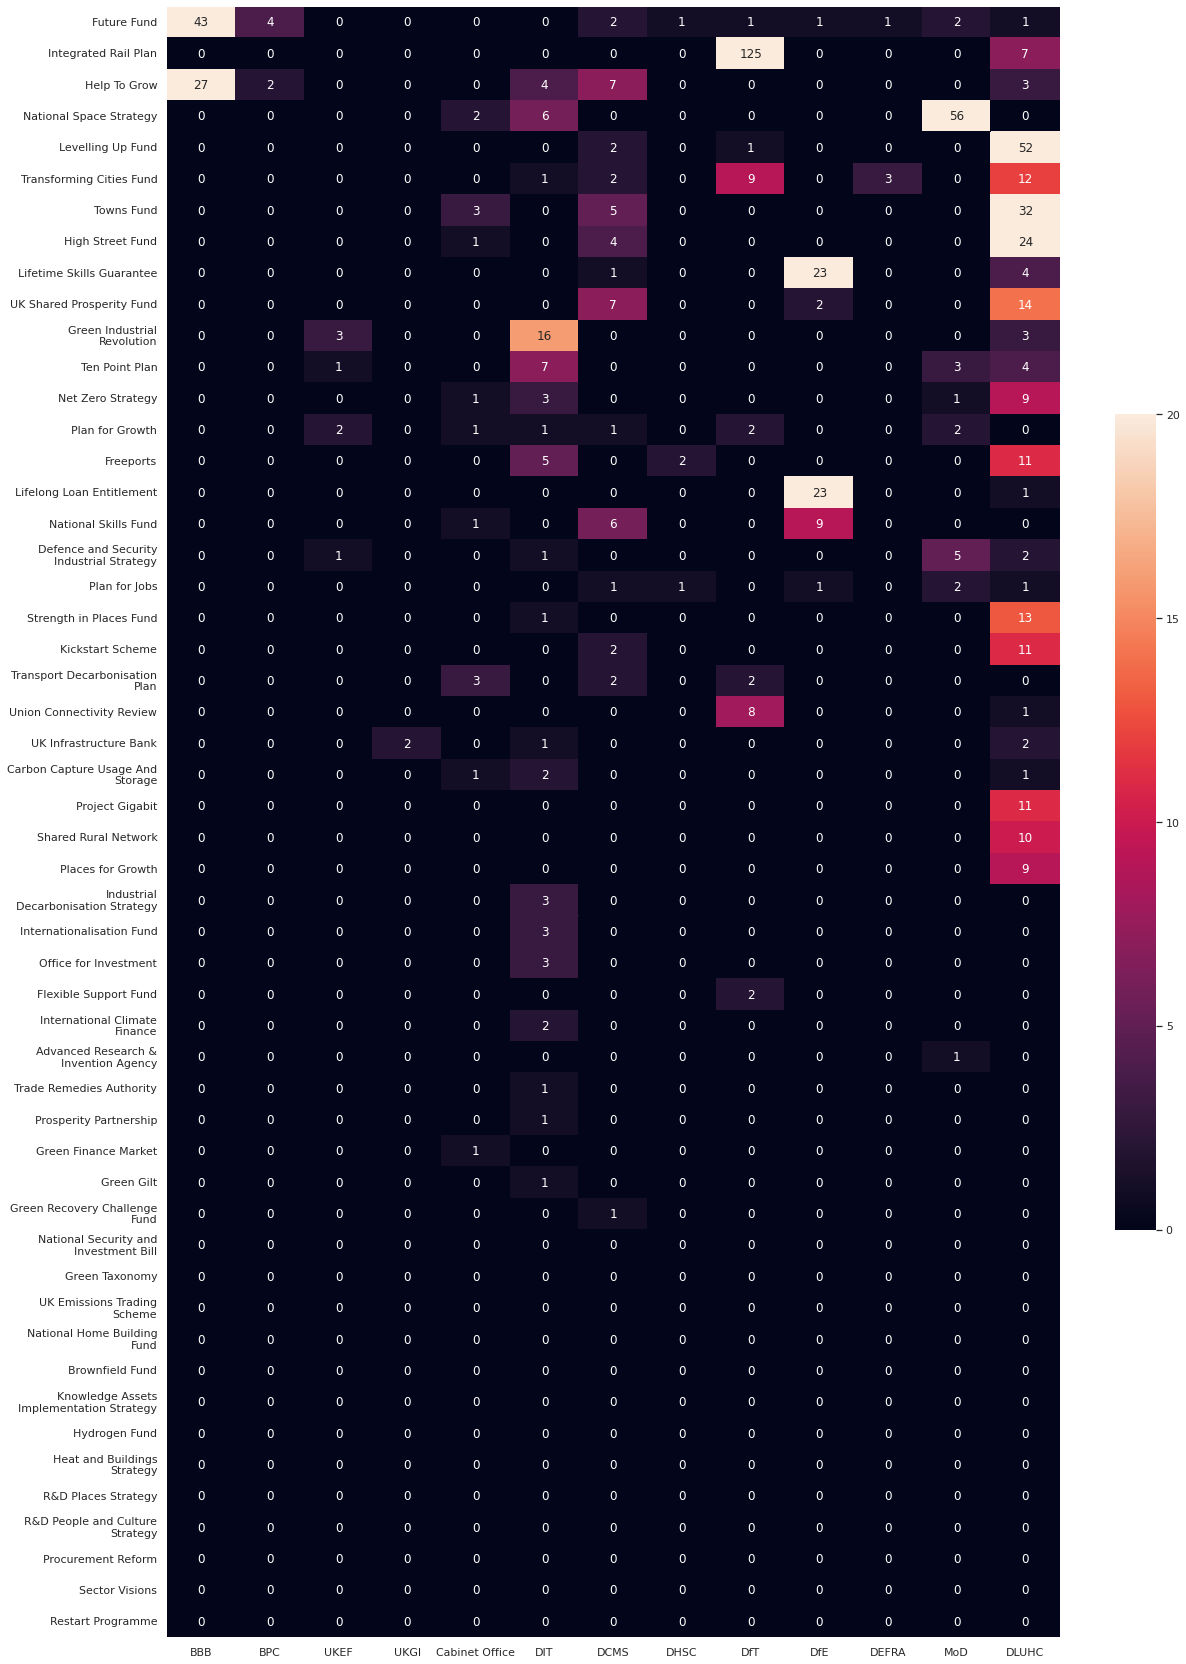

In [ ]:
#@title Heatmap of Plan for Growth terms
# Set the width and height of the figure
plt.figure(figsize = (20, 30))

# Generate a color palette with Seaborn.color_palette()
pal = sns.color_palette("rocket", as_cmap = True)

# Heatmap 
sns.set(font_scale = 1)
heatmap = sns.heatmap(plan_for_growth.iloc[:, 0:len(documents)],
                      annot = True,
                      vmin = 0,
                      vmax = 20,
                      cmap = pal,
                      cbar = True,
                      cbar_kws = dict(shrink = .5, ticks = range(0, 21, 5)),
                      yticklabels = True,
                      xticklabels = True,
                      fmt = "g")
wrap_xlabels(heatmap, 15)
wrap_ylabels(heatmap, 25)
heatmap

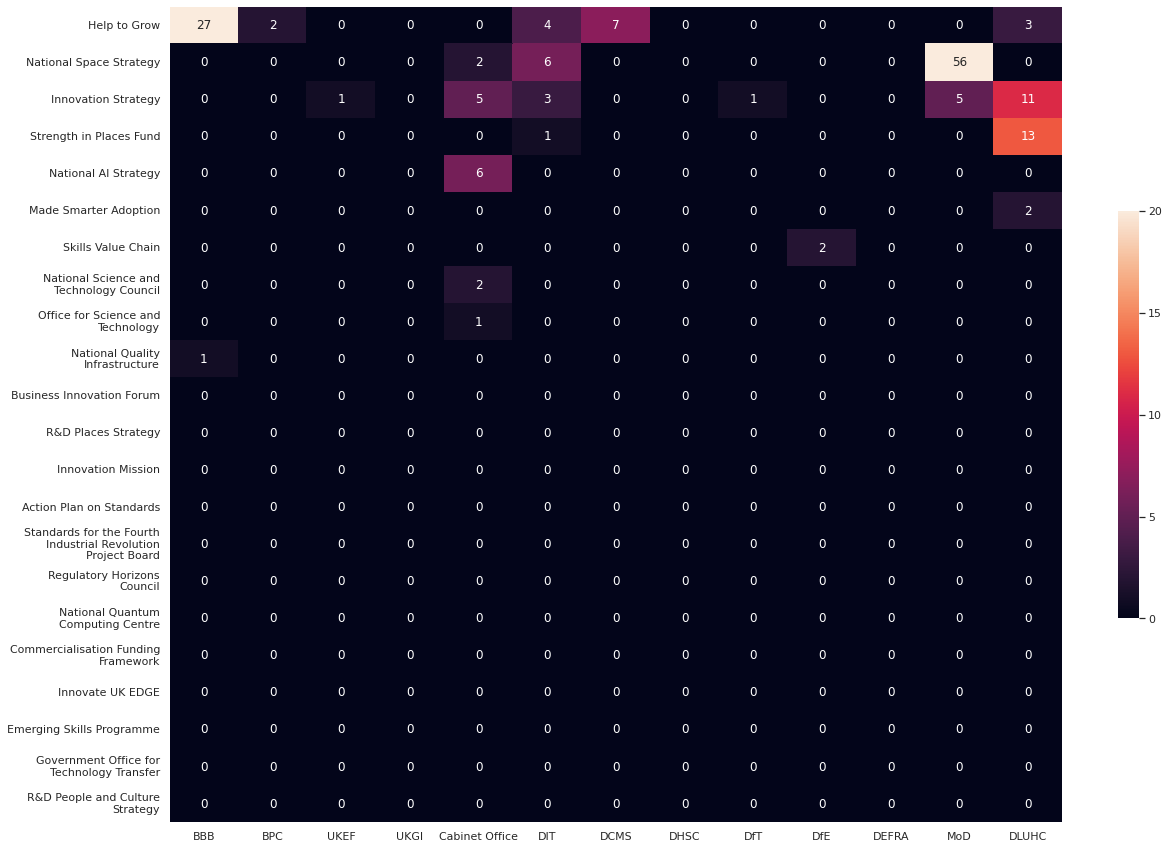

In [ ]:
#@title Heatmap of Innovation Stategy terms
# Set the width and height of the figure
plt.figure(figsize = (20, 15))

# Generate a color palette with Seaborn.color_palette()
pal = sns.color_palette("rocket", as_cmap = True)

# Heatmap 
sns.set(font_scale = 1)
heatmap = sns.heatmap(innovation_strategy.iloc[:, 0:len(documents)],
                      annot = True,
                      vmin = 0,
                      vmax = 20,
                      cmap = pal,
                      cbar = True,
                      cbar_kws = dict(shrink = .5, ticks = range(0, 21, 5)),
                      yticklabels = True,
                      xticklabels = True,
                      fmt = "g")
wrap_xlabels(heatmap, 15)
wrap_ylabels(heatmap, 25)
heatmap

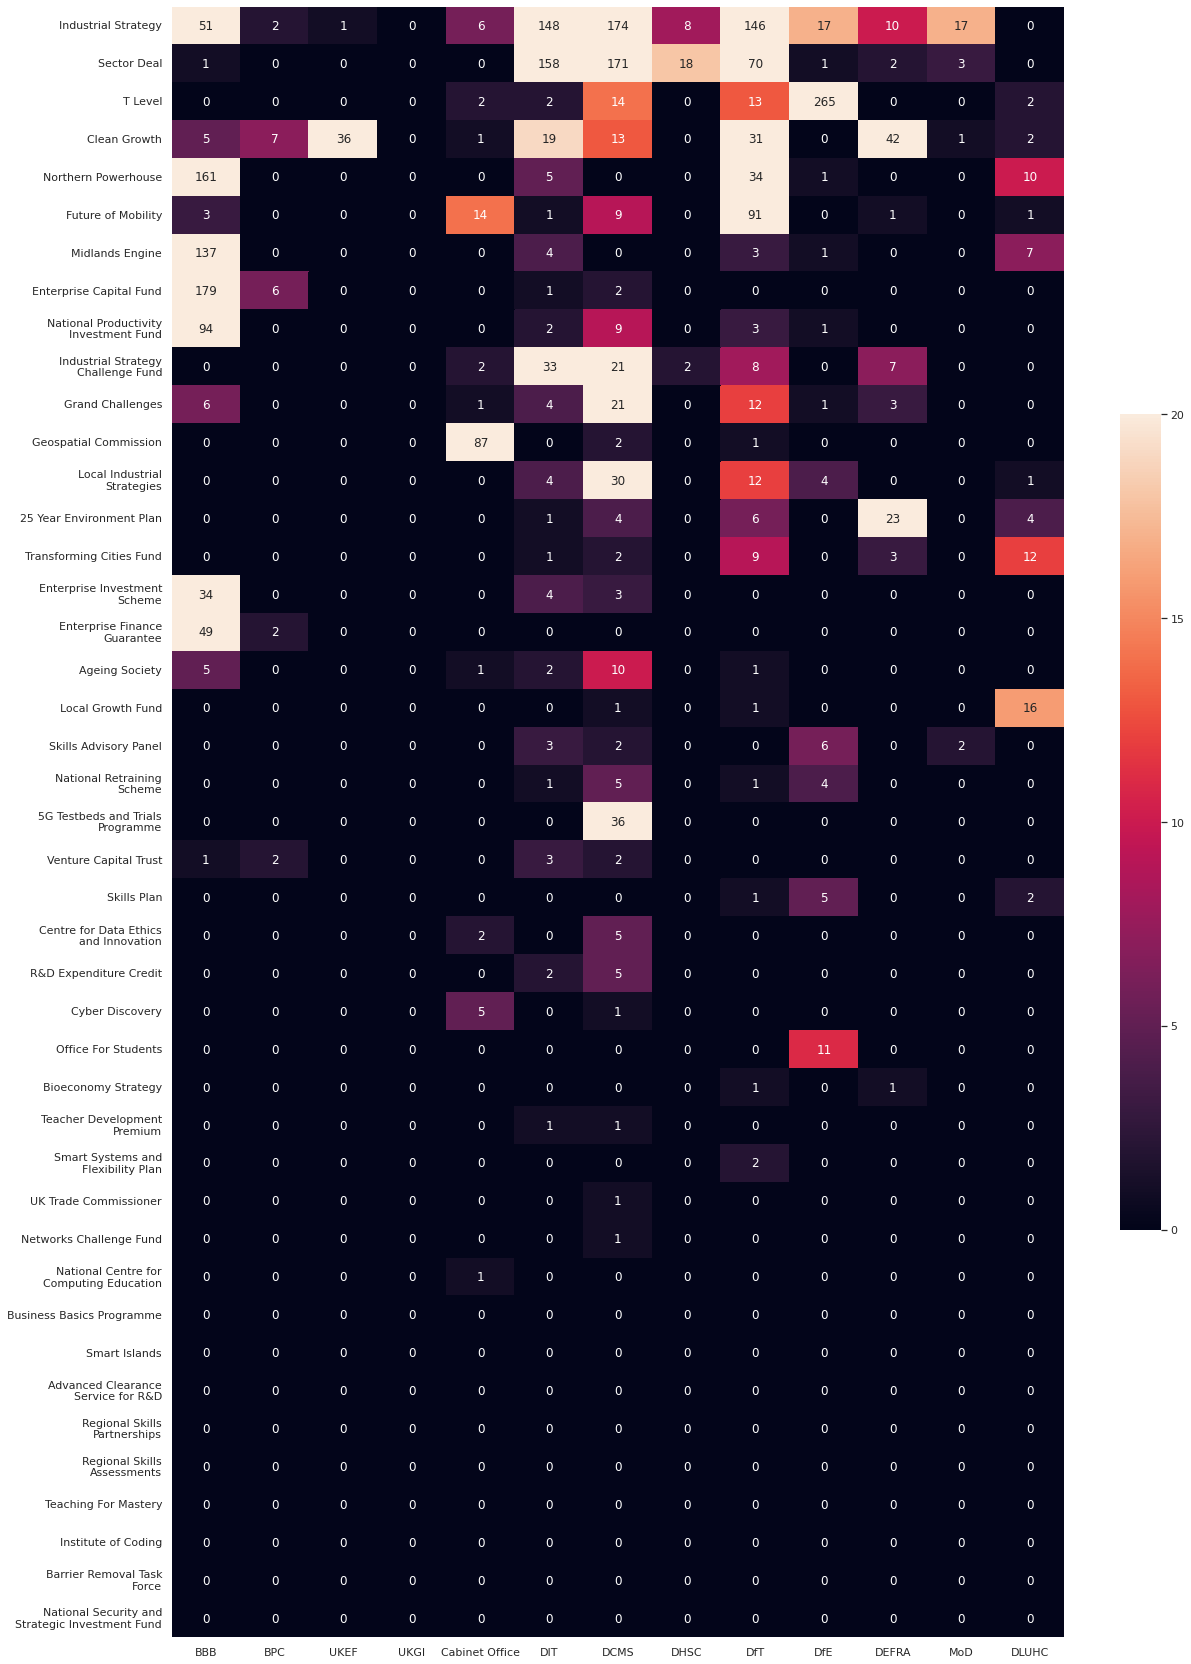

In [ ]:
#@title Heatmap of Industrial Stategy terms
# Set the width and height of the figure
plt.figure(figsize = (20, 30))

# Generate a color palette with Seaborn.color_palette()
pal = sns.color_palette("rocket", as_cmap = True)

# Heatmap 
sns.set(font_scale = 1)
heatmap = sns.heatmap(industrial_strategy.iloc[:, 0:len(documents)],
                      annot = True,
                      vmin = 0,
                      vmax = 20,
                      cmap = pal,
                      cbar = True,
                      cbar_kws = dict(shrink = .5, ticks = range(0, 21, 5)),
                      yticklabels = True,
                      xticklabels = True,
                      fmt = "g")
wrap_xlabels(heatmap, 15)
wrap_ylabels(heatmap, 25)
heatmap

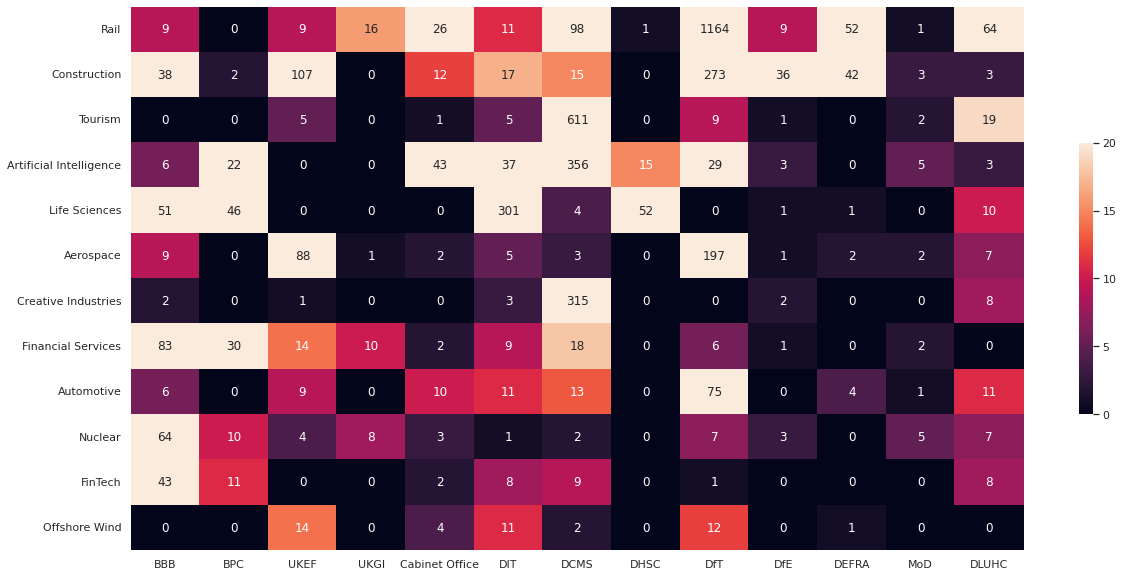

In [ ]:
#@title Heatmap of Economic Sector terms
# Set the width and height of the figure
plt.figure(figsize = (20, 10))

# Generate a color palette with Seaborn.color_palette()
pal = sns.color_palette("rocket", as_cmap = True)

# Heatmap 
sns.set(font_scale = 1)
heatmap = sns.heatmap(economic_sectors.iloc[:, 0:len(documents)],
                      annot = True,
                      vmin = 0,
                      vmax = 20,
                      cmap = pal,
                      cbar = True,
                      cbar_kws = dict(shrink = .5, ticks = range(0, 21, 5)),
                      yticklabels = True,
                      xticklabels = True,
                      fmt = "g")
wrap_xlabels(heatmap, 15)
wrap_ylabels(heatmap, 25)
heatmap

## Levelling Up White Paper subanalysis

In [ ]:
#@title LUWP - Plan for Growth dataframe
luwp_pfg = luwp.loc[["Plan For Growth", "Plan For Jobs", "Ten Point Plan",
                     "Green Industrial Revolution", "Heat And Buildings Strategy",
                     "Transport Decarbonisation Plan", "Transforming Cities Fund",
                     "Places For Growth", "Future Fund", "Levelling Up Fund",
                     "Uk Shared Prosperity Fund", "Flexible Support Fund",
                     "Lifetime Skills Guarantee", "Lifelong Loan Entitlement",
                     "Towns Fund", "High Street Fund", "Strength In Places Fund",
                     "Prosperity Partnership", "Help To Grow", "Kickstart Scheme",
                     "Restart Programme", "National Skills Fund", "Brownfield Fund",
                     "National Home Building Fund", "Freeports",
                     "Carbon Capture Usage And Storage", "Green Recovery Challenge Fund",
                     "Industrial Decarbonisation Strategy", "Net Zero Strategy",
                     "International Climate Finance", "Uk Emissions Trading Scheme",
                     "Green Gilt", "Green Finance Market", "Green Taxonomy",
                     "Uk Infrastructure Bank", "Office For Investment",
                     "National Security And Investment Bill",
                     "Integrated Rail Plan", "Union Connectivity Review",
                     "Project Gigabit", "Shared Rural Network",
                     "Advanced Research & Invention Agency",
                     "Internationalisation Fund", "Trade Remedies Authority",
                     "Knowledge Assets Implementation Strategy",
                     "Hydrogen Fund", "National Space Strategy",
                     "R&D Places Strategy", "R&D People And Culture Strategy",
                     "Procurement Reform", "Sector Visions",
                     "Defence And Security Industrial Strategy"]]

luwp_pfg = luwp_pfg.rename(index = {"Plan For Growth":"Plan for Growth",
                                    "Plan For Jobs":"Plan for Jobs",
                                    "Places For Growth":"Places for Growth",
                                    "Uk Shared Prosperity Fund":"UK Shared Prosperity Fund",
                                    "Strength In Places Fund":"Strength in Places Fund",
                                    "Uk Emissions Trading Scheme":"UK Emissions Trading Scheme",
                                    "Uk Infrastructure Bank":"UK Infrastructure Bank",
                                    "Heat And Buildings Strategy":"Heat and Buildings Strategy",
                                    "Office For Investment":"Office for Investment",
                                    "National Security And Investment Bill":"National Security and Investment Bill",
                                    "Defence And Security Industrial Strategy":"Defence and Security Industrial Strategy",
                                    "R&D People And Culture Strategy":"R&D People and Culture Strategy"})

luwp_pfg = luwp_pfg.sort_values(by = "Weighted Average Citation",
                                ascending = False)

In [ ]:
#@title LUWP - Innovation Strategy dataframe
luwp_innovstrat = luwp.loc[["Innovation Strategy", "Innovation Mission",
                            "Strength In Places Fund", "Help To Grow",
                            "Emerging Skills Programme",
                            "National Quantum Computing Centre",
                            "National Science And Technology Council",
                            "Office For Science And Technology",
                            "Business Innovation Forum", "National Space Strategy",
                            "R&D Places Strategy", "R&D People And Culture Strategy",
                            "Action Plan On Standards", "Regulatory Horizons Council",
                            "Standards For The Fourth Industrial Revolution Project Board",
                            "National Quality Infrastructure", "National Ai Strategy",
                            "Commercialisation Funding Framework",
                            "Innovate Uk Edge", "Made Smarter Adoption",
                            "Government Office For Technology Transfer",
                            "Skills Value Chain"]]

luwp_innovstrat = luwp_innovstrat.rename(index = {"Strength In Places Fund":"Strength in Places Fund",
                                                  "Help To Grow":"Help to Grow",
                                                  "National Science And Technology Council":"National Science and Technology Council",
                                                  "Office For Science And Technology":"Office for Science and Technology",
                                                  "R&D People And Culture Strategy":"R&D People and Culture Strategy",
                                                  "Action Plan On Standards":"Action Plan on Standards",
                                                  "Standards For The Fourth Industrial Revolution Project Board":"Standards for the Fourth Industrial Revolution Project Board",
                                                  "National Ai Strategy":"National AI Strategy",
                                                  "Innovate Uk Edge":"Innovate UK EDGE",
                                                  "Government Office For Technology Transfer":"Government Office for Technology Transfer"})

luwp_innovstrat = luwp_innovstrat.sort_values(by = "Weighted Average Citation",
                                              ascending = False)

In [ ]:
#@title LUWP - 2017 Industrial Strategy dataframe
luwp_indstrat = luwp.loc[["Industrial Strategy", "Grand Challenges",
                          "Industrial Strategy Challenge Fund",
                          "Local Industrial Strategies", "Sector Deal",
                          "Transforming Cities Fund",
                          "National Productivity Investment Fund",
                          "5G Testbeds And Trials Programme", "Midlands Engine",
                          "Northern Powerhouse", "National Retraining Scheme",
                          "Teacher Development Premium", "Office For Students",
                          "Skills Plan", "Teaching For Mastery", "T Level",
                          "Cyber Discovery", "Institute Of Coding",
                          "National Centre For Computing Education",
                          "Smart Systems And Flexibility Plan", "Smart Islands",
                          "Local Growth Fund", "Bioeconomy Strategy",
                          "Barrier Removal Task Force", "Networks Challenge Fund",
                          "Geospatial Commission",
                          "Centre For Data Ethics And Innovation",
                          "Venture Capital Trust", "Enterprise Investment Scheme",
                          "Enterprise Capital Fund", "Enterprise Finance Guarantee",
                          "National Security And Strategic Investment Fund",
                          "Business Basics Programme", "Uk Trade Commissioner",
                          "R&D Expenditure Credit", "Advanced Clearance Service For R&D",
                          "Regional Skills Partnerships", "Regional Skills Assessments",
                          "Skills Advisory Panel", "25 Year Environment Plan",
                          "Ageing Society", "Clean Growth", "Future Of Mobility"]]

luwp_indstrat = luwp_indstrat.rename(index = {"5G Testbeds And Trials Programme":"5G Testbeds and Trials Programme",
                                              "Institute Of Coding":"Institute of Coding",
                                              "National Centre For Computing Education":"National Centre for Computing Education",
                                              "Smart Systems And Flexibility Plan":"Smart Systems and Flexibility Plan",
                                              "Centre For Data Ethics And Innovation":"Centre for Data Ethics and Innovation",
                                              "National Security And Strategic Investment Fund":"National Security and Strategic Investment Fund",
                                              "Advanced Clearance Service For R&D":"Advanced Clearance Service for R&D",
                                              "Uk Trade Commissioner":"UK Trade Commissioner",
                                              "Future Of Mobility":"Future of Mobility"})

luwp_indstrat = luwp_indstrat.sort_values(by = "Weighted Average Citation",
                                          ascending = False)

In [ ]:
#@title LUWP - Economic sector terms dataframe
luwp_econsec = luwp.loc[["Aerospace", "Automotive", "Construction",
                         "Creative Industries", "Life Sciences",
                         "Nuclear", "Offshore Wind", "Rail",
                         "Tourism", "Artificial Intelligence",
                         "Financial Services", "Fintech",]]

luwp_econsec = luwp_econsec.rename(index = {"Fintech":"FinTech"})

luwp_econsec = luwp_econsec.sort_values(by = "Weighted Average Citation",
                                                ascending = False)

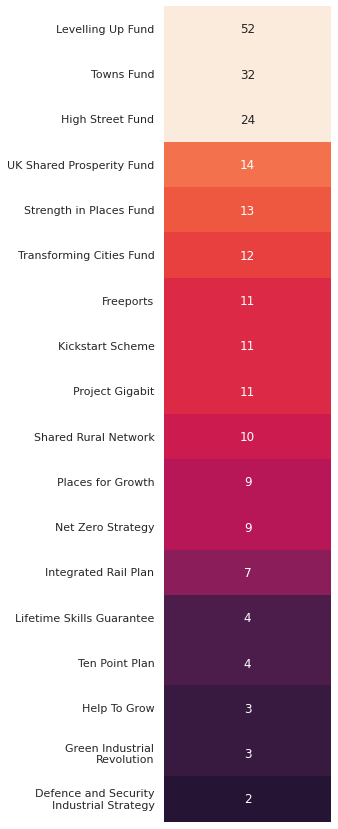

In [ ]:
#@title Heatmap of LUWP - Plan for Growth terms I
# Set the width and height of the figure
plt.figure(figsize = (3, 15))

# Generate a color palette with Seaborn.color_palette()
pal = sns.color_palette("rocket", as_cmap = True)

# Heatmap 
sns.set(font_scale = 1)
heatmap = sns.heatmap(luwp_pfg.iloc[0:18, 0:1],
                      annot = True,
                      vmin = 0,
                      vmax = 20,
                      cmap = pal,
                      cbar = False,
                      cbar_kws = dict(shrink = .5, ticks = range(0, 21, 5)),
                      yticklabels = True,
                      xticklabels = False,
                      fmt = "g")
wrap_xlabels(heatmap, 15)
wrap_ylabels(heatmap, 25)
heatmap

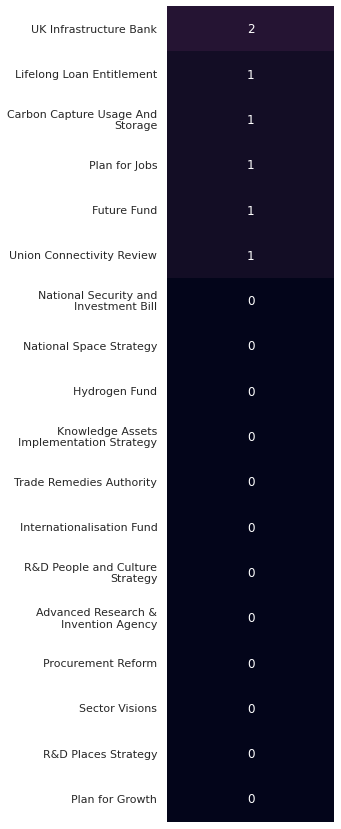

In [ ]:
#@title Heatmap of LUWP - Plan for Growth terms II
# Set the width and height of the figure
plt.figure(figsize = (3, 15))

# Generate a color palette with Seaborn.color_palette()
pal = sns.color_palette("rocket", as_cmap = True)

# Heatmap 
sns.set(font_scale = 1)
heatmap = sns.heatmap(luwp_pfg.iloc[18:36, 0:1],
                      annot = True,
                      vmin = 0,
                      vmax = 20,
                      cmap = pal,
                      cbar = False,
                      cbar_kws = dict(shrink = .5, ticks = range(0, 21, 5)),
                      yticklabels = True,
                      xticklabels = False,
                      fmt = "g")
wrap_xlabels(heatmap, 15)
wrap_ylabels(heatmap, 25)
heatmap

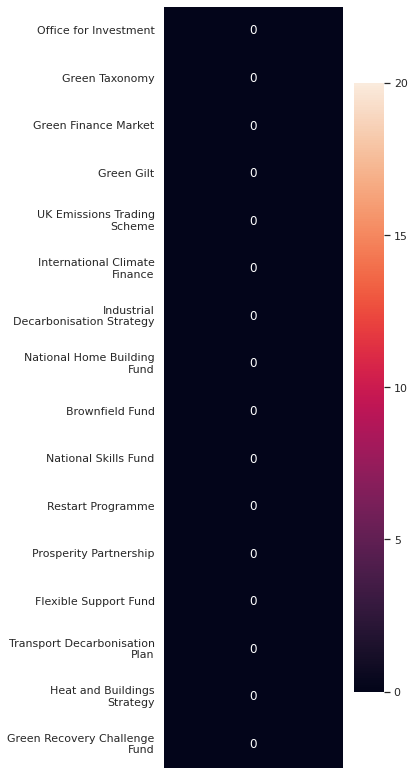

In [ ]:
#@title Heatmap of LUWP - Plan for Growth terms III
# Set the width and height of the figure
plt.figure(figsize = (4, 14))

# Generate a color palette with Seaborn.color_palette()
pal = sns.color_palette("rocket", as_cmap = True)

# Heatmap 
sns.set(font_scale = 1)
heatmap = sns.heatmap(luwp_pfg.iloc[36:, 0:1],
                      annot = True,
                      vmin = 0,
                      vmax = 20,
                      cmap = pal,
                      cbar = True,
                      cbar_kws = dict(shrink = 0.8, ticks = range(0, 21, 5)),
                      yticklabels = True,
                      xticklabels = False,
                      fmt = "g")
wrap_xlabels(heatmap, 15)
wrap_ylabels(heatmap, 25)
heatmap

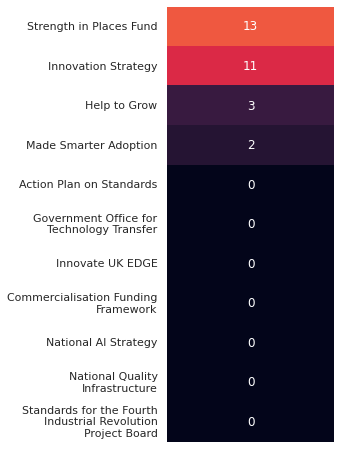

In [ ]:
#@title Heatmap of LUWP - Innovation Strategy terms I
# Set the width and height of the figure
plt.figure(figsize = (3, 8))

# Generate a color palette with Seaborn.color_palette()
pal = sns.color_palette("rocket", as_cmap = True)

# Heatmap 
sns.set(font_scale = 1)
heatmap = sns.heatmap(luwp_innovstrat.iloc[0:11, 0:1],
                      annot = True,
                      vmin = 0,
                      vmax = 20,
                      cmap = pal,
                      cbar = False,
                      cbar_kws = dict(shrink = .5, ticks = range(0, 21, 5)),
                      yticklabels = True,
                      xticklabels = False,
                      fmt = "g")
wrap_xlabels(heatmap, 15)
wrap_ylabels(heatmap, 25)
heatmap

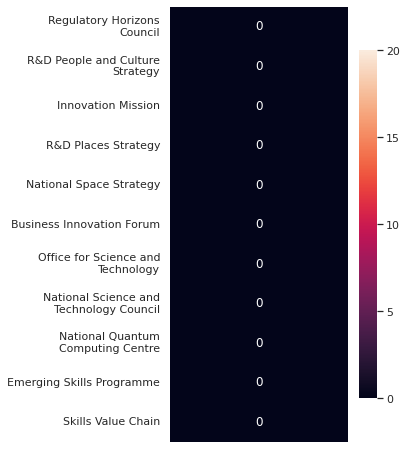

In [ ]:
#@title Heatmap of LUWP - Innovation Strategy terms II
# Set the width and height of the figure
plt.figure(figsize = (4, 8))

# Generate a color palette with Seaborn.color_palette()
pal = sns.color_palette("rocket", as_cmap = True)

# Heatmap 
sns.set(font_scale = 1)
heatmap = sns.heatmap(luwp_innovstrat.iloc[11:, 0:1],
                      annot = True,
                      vmin = 0,
                      vmax = 20,
                      cmap = pal,
                      cbar = True,
                      cbar_kws = dict(shrink = .8, ticks = range(0, 21, 5)),
                      yticklabels = True,
                      xticklabels = False,
                      fmt = "g")
wrap_xlabels(heatmap, 15)
wrap_ylabels(heatmap, 25)
heatmap

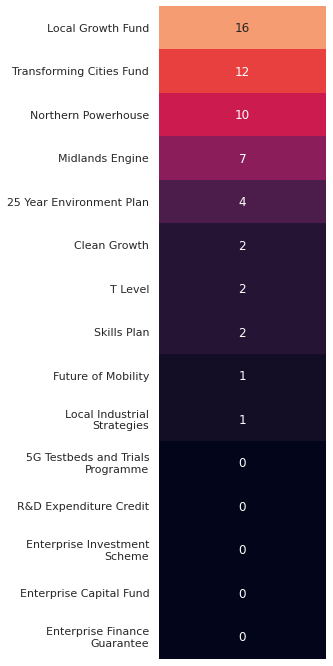

In [ ]:
#@title Heatmap of LUWP - 2017 Industrial Strategy terms I
# Set the width and height of the figure
plt.figure(figsize = (3, 12))

# Generate a color palette with Seaborn.color_palette()
pal = sns.color_palette("rocket", as_cmap = True)

# Heatmap 
sns.set(font_scale = 1)
heatmap = sns.heatmap(luwp_indstrat.iloc[0:15, 0:1],
                      annot = True,
                      vmin = 0,
                      vmax = 20,
                      cmap = pal,
                      cbar = False,
                      cbar_kws = dict(shrink = .5, ticks = range(0, 21, 5)),
                      yticklabels = True,
                      xticklabels = False,
                      fmt = "g")
wrap_xlabels(heatmap, 15)
wrap_ylabels(heatmap, 25)
heatmap

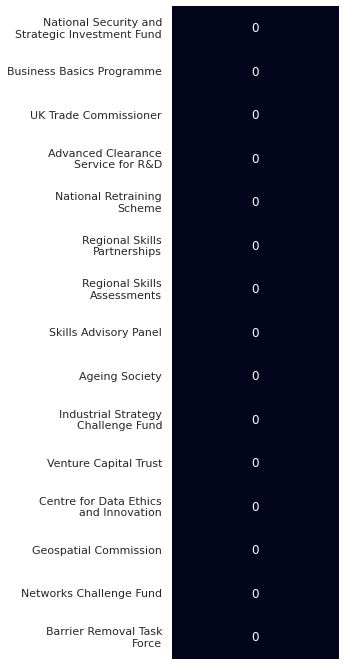

In [ ]:
#@title Heatmap of LUWP - 2017 Industrial Strategy terms II
# Set the width and height of the figure
plt.figure(figsize = (3, 12))

# Generate a color palette with Seaborn.color_palette()
pal = sns.color_palette("rocket", as_cmap = True)

# Heatmap 
sns.set(font_scale = 1)
heatmap = sns.heatmap(luwp_indstrat.iloc[15:30, 0:1],
                      annot = True,
                      vmin = 0,
                      vmax = 20,
                      cmap = pal,
                      cbar = False,
                      cbar_kws = dict(shrink = .5, ticks = range(0, 21, 5)),
                      yticklabels = True,
                      xticklabels = False,
                      fmt = "g")
wrap_xlabels(heatmap, 15)
wrap_ylabels(heatmap, 25)
heatmap

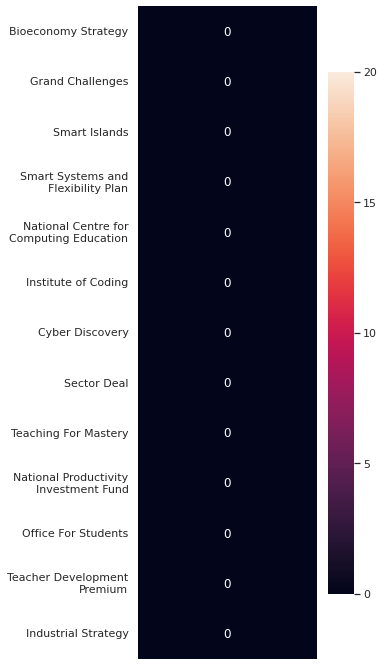

In [ ]:
#@title Heatmap of LUWP - 2017 Industrial Strategy terms III
# Set the width and height of the figure
plt.figure(figsize = (4, 12))

# Generate a color palette with Seaborn.color_palette()
pal = sns.color_palette("rocket", as_cmap = True)

# Heatmap 
sns.set(font_scale = 1)
heatmap = sns.heatmap(luwp_indstrat.iloc[30:, 0:1],
                      annot = True,
                      vmin = 0,
                      vmax = 20,
                      cmap = pal,
                      cbar = True,
                      cbar_kws = dict(shrink = .8, ticks = range(0, 21, 5)),
                      yticklabels = True,
                      xticklabels = False,
                      fmt = "g")
wrap_xlabels(heatmap, 15)
wrap_ylabels(heatmap, 25)
heatmap

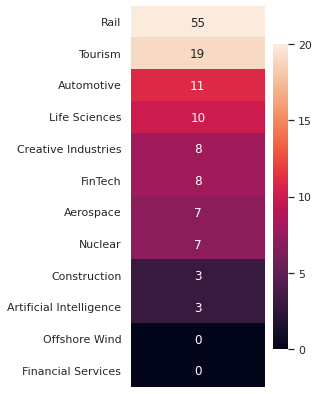

In [ ]:
#@title Heatmap of LUWP - Economic sector terms
# Set the width and height of the figure
plt.figure(figsize = (3, 7))

# Generate a color palette with Seaborn.color_palette()
pal = sns.color_palette("rocket", as_cmap = True)

# Heatmap 
sns.set(font_scale = 1)
heatmap = sns.heatmap(luwp_econsec.iloc[:, 0:1],
                      annot = True,
                      vmin = 0,
                      vmax = 20,
                      cmap = pal,
                      cbar = True,
                      cbar_kws = dict(shrink = .8, ticks = range(0, 21, 5)),
                      yticklabels = True,
                      xticklabels = False,
                      fmt = "g")
wrap_xlabels(heatmap, 15)
wrap_ylabels(heatmap, 25)
heatmap